In [258]:
##  ***LIBRARY IMPORTS                           ***
import math ## Mainly for sqrt function
import numpy as np ## For tranformations to multidimensional arrays
from tensorflow import keras ## For model building
import tensorflow as tf ## For model building
from matplotlib import pyplot ## For all charts
import pandas as pd ## To create and manipulate pandas DataFrames
from sklearn.preprocessing import MinMaxScaler ## To Normalize data
from sklearn.metrics import mean_squared_error ## MSE to measure error in model
from keras.models import Sequential ## To create sequential() models
from keras.layers import Dense, LSTM, Activation, Dropout, Embedding, Conv1D, MaxPooling2D, Flatten
from keras import optimizers ## To manipulate optimizers such as adam, sgd etc.

In [ ]:
##  ***TABLE OF CONTENTS                         ***
##     1. Data Overview
##     2. Library Imports
##     3. Time-Step Function
##     4. Dataset Import & Initial Exploration
##     5. Preprocessing & Exploration
##        a. Train, Test Split
##        b. Shape Exploration
##        c. Set Verification
##     6. Normalization
##        a. MinMaxScaler
##     7. Shape Transformation
##        a. Modifying Dimensionality
##     8. Model Construction
##        a. LSTM Layers
##        b. Dropout
##        c. Activation
##        d. Metrics
##        e. Model Summary
##        f. Model Predictions
##     9. Error Exploration
##        a. Plot: Training vs. Test Error
##        b. Sample Predictions
##        c. Plot: Predicted vs. Target Temp

In [259]:
##  ***OBJECTIVE                                 ***
##  The problem is a multivariate forecasting problem. Given a historical
##  data of climate conditions, you predict the temperature of the next hour
##  based on the climate conditions and temperature over the last 24 hours

In [260]:
##  ***DATA OVERVIEW                             ***
##  The dataset, climate_hour.csv, is a truncated version of a dataset that
##  contains weather conditions from the weather station at the Max Planck
##  Institute for Biochemistry in Jena Germany.
##  Our truncated set includes data from 2009 to 2017 (70,037 entries)
##  Our goal is to use time-series to predict a temperature given all data
##  from the past 24 hours (including temperatures from those hours).

In [261]:
##  ***LIBRARY IMPORTS                           ***
import math ## Mainly for sqrt function
import numpy as np ## For tranformations to multidimensional arrays
from tensorflow import keras ## For model building
import tensorflow as tf ## For model building
from matplotlib import pyplot ## For all charts
import pandas as pd ## To create and manipulate pandas DataFrames
from sklearn.preprocessing import MinMaxScaler ## To Normalize data
from sklearn.metrics import mean_squared_error ## MSE to measure error in model
from keras.models import Sequential ## To create sequential() models
from keras.layers import Dense, LSTM, Activation, Dropout, Embedding, Conv1D, MaxPooling2D, Flatten
from keras import optimizers ## To manipulate optimizers such as adam, sgd etc.

In [262]:
##  ***TIME STEP FUNCTION                        ***
def time_func(index, values, n_in=1, n_out=1, dropnan=True):
    
    n_vars = 1 if type(values) is list else values.shape[1]
    
    df = pd.DataFrame(values)
    
    cols, names = list(), list()
    
    df = dataset
    
    
    newtuple = list()
    
    for i in range(24, 0, -1):
        
        newtuple.append(df.shift(i))
    
    
    
    
    agg = pd.concat(newtuple, axis=1)
    
    
    return agg   
    ## Creating new dataframe out of shifted data
    new = pd.DataFrame(agg)
    new.index = index
    
    ## Removing NaN values which occur naturally because the first date
    ## in the series (01.01.09) doesn't have any data to "look back" to
    if dropnan:
        new.dropna(inplace=True)
        
    return new    

In [263]:
##  ***DATASET IMPORT                            ***
dataset = pd.read_csv('climate_hour.csv', header=0, index_col=0)

##  Reformatting as Array
values = dataset.values
index = dataset.index

y_orig = dataset.loc['01.01.2015 00:00:00' : '01.01.2017 00:00:00']
y_orig = y_orig.values
y_orig = y_orig[:,1]

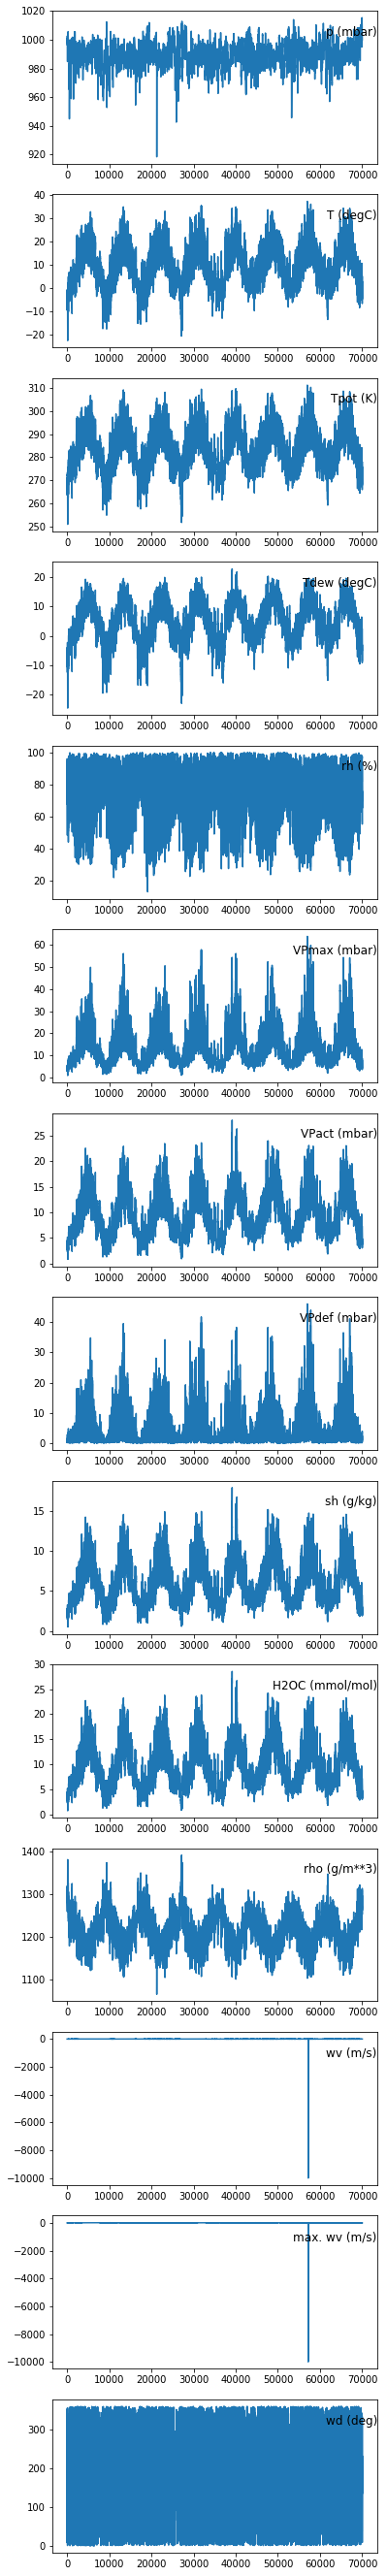

In [264]:
##  ***INITIAL EXPLORATION                       ***
##  Plotting the overall distribution of each feature can give an
##  idea of how the data are related. Some features, like T(degC),
##  TPot(K), and TDew(degC) look like they may be positively correlated.
##  Also, it alerts us to the fact that in wv(m/s) and max.wv(m/s)
##  there is some noise (particularly for 7/13/2015, 9AM-12P).
##  Additionally, we can see that wd(deg) probably does not give
##  us much information, as it ranges in value from .02 to 360
##  And doesn't seem to give us much of a pattern. It is my opinion
##  that this feature can be removed. 

groups = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
i = 1
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.subplots_adjust(top = 20, bottom = 10.9)
    pyplot.plot(values[:,group])
    pyplot.title(dataset.columns[group], y=.8, loc='right')
    i += 1
pyplot.show()  

In [265]:
##  Isolating noise from: 7/13/2015, 9AM-12P
print(dataset.loc['13.07.2015 09:00:00': '13.07.2015 12:00:00'])

                     p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
Date Time                                                                
13.07.2015 09:00:00    990.52     16.98    290.93        12.94   77.10   
13.07.2015 10:00:00    990.20     17.98    291.96        12.74   71.40   
13.07.2015 11:00:00    990.16     18.71    292.70        12.48   67.07   
13.07.2015 12:00:00    990.15     18.75    292.74        12.27   65.97   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                                  
13.07.2015 09:00:00         19.38         14.94          4.44       9.44   
13.07.2015 10:00:00         20.65         14.74          5.90       9.31   
13.07.2015 11:00:00         21.61         14.50          7.12       9.16   
13.07.2015 12:00:00         21.67         14.29          7.37       9.03   

                     H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  \
Date Time          

In [266]:
##  Since all other values in these columns are relatively low, I'll simply give 
##  these values '0' to help eliminate the noise

values[57208:57209, 12:13] = 0
values[57209:57210, 12:13] = 0
values[57210:57211, 12:13] = 0
values[57208:57209, 11:12] = 0
values[57209:57210, 11:12] = 0
values[57210:57211, 11:12] = 0
values[57207:57208, 12:13] = 0



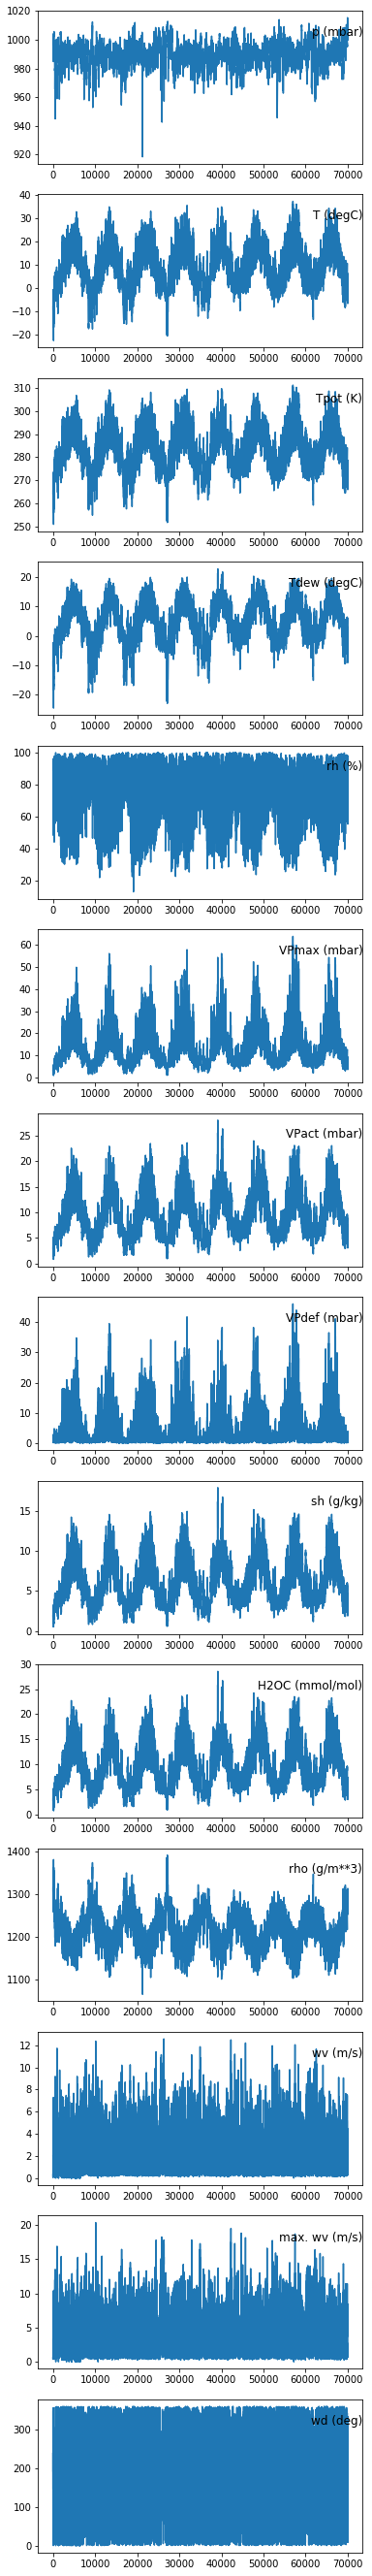

In [267]:
##  We can look at the graphs again and see that the distribution for the noisy columns
##  is now much different.

groups = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
i = 1
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.subplots_adjust(top = 20, bottom = 10.9)
    pyplot.plot(values[:,group])
    pyplot.title(dataset.columns[group], y=.8, loc='right')
    i += 1
pyplot.show()  

In [268]:
##  ***NORMALIZATION                                   ***
##  Normalizing data using MinMaxScaler
##  Note, this was done after the data was split because I wanted to be
##  able to compare the training and test data to "prepared_data.html"
##  before it was normalized.

##  Normalizing all data to range from 0 to 1


yscaler = MinMaxScaler(feature_range=(0,1))
yscale = values[:,1]
yscalevals = yscale.reshape(-1, 1)
Y_scaled = yscaler.fit_transform(yscalevals)

scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

sc = pd.DataFrame(Y_scaled)
sc.index = dataset.index

In [269]:
##  Passing values to a function to convert the series to be transformed
##  to the correct shape for a supervised learning problem (like Time Series
##  Forecasting with LSTM)
##  Note, I passed the original dataframe index so I could use it on the
##  Formatted data. This is because I wanted a simple way to split the
##  Data once it was transformed.

formatted = time_func(index, values, 23, 1)

In [270]:
##  Double checking shape: confirmed 360 columns as expected

formatted.shape

(70037, 336)

In [271]:
##  ***TRAIN - TEST SPLIT                        ***
##  Splitting data into test and train, based on date indices

x_train = formatted.loc['02.01.2009 01:00:00': '31.12.2014 23:00:00']



y_train = sc.loc['01.01.2009 01:00:00' : '31.12.2014 22:00:00']


x_test = formatted.loc['30.12.2014 23:00:00' : '01.01.2017 00:00:00']

y_test = sc.loc['01.01.2015 01:00:00' : '01.01.2017 00:00:00']



FinalIndex = y_test.index

In [272]:
##  ***SHAPE EXPLORATION                          ***
##  Converting all Pandas DataFrames to Numpy Representations

x_train = x_train.values
x_test = x_test.values
y_train = y_train.values
y_test = y_test.values

##  Reshaping y vectors, because MinMax scaling (below) requires a 
##  two-dimensional representation.

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


##  Exploring Shapes of Various Data Sets
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(52542, 336) (17496, 336) (52565, 1) (17470, 1)


In [273]:
print(x_test[:3])
print(x_test[-3:])

[[1007.52   -4.66  267.93 ...    3.36    4.55  254.6 ]
 [1007.28   -5.07  267.54 ...    2.89    4.33  253.9 ]
 [1007.08   -4.79  267.83 ...    2.12    3.47  260.7 ]]
[[ 1.00893e+03 -2.63000e+00  2.69840e+02 ...  6.10000e-01  1.48000e+00
   2.07500e+02]
 [ 1.00882e+03 -2.98000e+00  2.69500e+02 ...  3.80000e-01  7.20000e-01
   8.15000e+00]
 [ 1.00867e+03 -4.09000e+00  2.68410e+02 ...  8.90000e-01  1.30000e+00
   2.23700e+02]]


In [158]:
##  ***SHAPE TRANSFORMATION                            ***
##  Now that normalization is done, we can re-shape the ytrain and ytest
##  vectors

ytrain = y_train.reshape(len(y_train[:,0]),)
ytest = y_test.reshape(len(y_test[:,0]),)

##  Checking vectors have been re-shaped correctly

print(ytrain.shape)
print(ytest.shape)

(52542,)
(17471,)


In [159]:
##  Verifying that data is still shaped as expected after transformations and
##  splitting, etc.

print(x_train.shape, len(x_train), ytrain.shape)
print(x_test.shape, len(x_test), ytest.shape)

(52542, 336) 52542 (52542,)
(17471, 336) 17471 (17471,)


In [160]:
##  ***MODIFYING DIMENSIONALITY                        ***
##  Number of data dimensions is equal to the number of features: 14


data_dim = 14

##  Timesteps, for our problem, is equal to the number of hours in a day: 24

timesteps= 24

##  Reshaping training and test vectors to become 3-Dimensional
##  This is required for LSTM models.
##  The new shape must be: (#samples, #timesteps, #features)

xtrain = x_train.reshape((x_train.shape[0], timesteps, data_dim))
xtest = x_test.reshape((x_test.shape[0], timesteps, data_dim))

##  Checking to ensure training and test vectors are now 3-Dimensional
print(xtrain.shape, xtest.shape)
print(ytrain.shape, ytest.shape)

(52542, 24, 14) (17471, 24, 14)
(52542,) (17471,)


In [161]:
##  ***MODEL CONSTRUCTION                              ***
##  Building the Model
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
rms = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=1e-6)

model = Sequential()

model.add(LSTM(50, input_shape=(timesteps, data_dim)))

model.add(Dense(1))

model.compile(loss='mae', optimizer= rms)

model.summary()

history = model.fit(xtrain, ytrain, epochs=30, batch_size=75, 
                    validation_data=(xtest, ytest), verbose=2, shuffle=False)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 50)                13000     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
Total params: 13,051
Trainable params: 13,051
Non-trainable params: 0
_________________________________________________________________
Train on 52542 samples, validate on 17471 samples
Epoch 1/30
 - 10s - loss: 0.0627 - val_loss: 0.0385
Epoch 2/30
 - 8s - loss: 0.0267 - val_loss: 0.0266
Epoch 3/30
 - 8s - loss: 0.0193 - val_loss: 0.0183
Epoch 4/30
 - 8s - loss: 0.0148 - val_loss: 0.0119
Epoch 5/30
 - 8s - loss: 0.0125 - val_loss: 0.0088
Epoch 6/30
 - 8s - loss: 0.0115 - val_loss: 0.0086
Epoch 7/30
 - 8s - loss: 0.0110 - val_loss: 0.0088
Epoch 8/30
 - 8s - loss: 0.0106 - val_loss: 0.0085
Epoch 9/30
 - 8s - loss: 0.0103 - val_loss: 0.0085
Epoch 10/30
 - 8s - loss

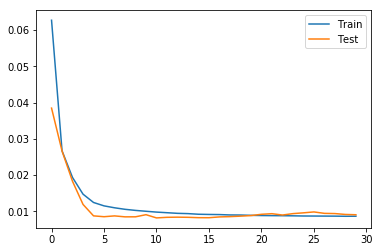

In [162]:
## Plotting the loss on the Training vs. the Test set

pyplot.plot(history.history['loss'], label='Train')
pyplot.plot(history.history['val_loss'], label='Test')
pyplot.legend()
pyplot.show()

In [167]:
prediction = model.predict(xtest)



inv = yscaler.inverse_transform(prediction)



rmse = math.sqrt(mean_squared_error(inv, y_orig))
print('Test RMSE: %.3F' % rmse)

Test RMSE: 0.730


In [ ]:
##  Creating new DataFrame to hold results

predicted = pd.DataFrame(inv, columns={'temperature'})

predicted.index = FinalIndex
predicted.index = pd.to_datetime(predicted.index, format = '%d.%m.%Y %H:%M:%S').strftime('%d.%m.%Y_%H:%M:%S')
predicted.index.name = 'date_time'

In [ ]:
##  Saving results to CSV for Kaggle upload

predicted.to_csv('HRABIK_try_14.csv')